In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Saved the keypoints for the training, validation, and test sets to not recompute everytime.

In [ ]:
!wget -nc "https://www.dropbox.com/scl/fi/eipoqmbu26psz4nih7u81/keypoints.tar?rlkey=z4j3nq2n29vb2ygjilmdta6ib&st=6a9pp8ij&dl=1" -O keypoints.tar.gz
!tar xf keypoints.tar.gz

!wget -nc "https://www.dropbox.com/scl/fi/p1oz82wve295got4epwlx/keypoints_test.tar?rlkey=zibbcvlexk462trmakh3wjnjt&st=x1nsq2zv&dl=1" -O keypoints_test.tar.gz
!tar xf keypoints_test.tar.gz

!wget -nc "https://www.dropbox.com/scl/fi/5ycxejy3ghc6t66oalcld/keypoints_val.tar?rlkey=3bo7tp2fthbiwla8f4jdv0vsm&st=wpnjoqcu&dl=1" -O keypoints_val.tar.gz
!tar xf keypoints_val.tar.gz

Streaming output truncated to the last 5000 lines.
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar

Download the data

In [ ]:
!wget -nc "https://www.dropbox.com/scl/fi/frhu0t3o8s87dwrxr37bn/train.tar?rlkey=mjqzz14h74p772z844nwj9w7o&st=p12c2f5r&dl=1" -O train.tar.gz
!tar xf train.tar.gz

!wget -nc "https://www.dropbox.com/scl/fi/ubthmyi356wpm7mjrzim0/val.tar?rlkey=rii6jdk5aj2javr9luepox7yc&st=fz0u9iaq&dl=1"   -O val.tar.gz
!tar xf val.tar.gz

!wget -nc "https://www.dropbox.com/scl/fi/qusyr5witnx49vi0whk28/test.tar?rlkey=nfa9bk2fxv31ntbmoz5bd9xxy&st=8wtto4ta&dl=1"  -O test.tar.gz
!tar xf test.tar.gz

--2025-05-01 22:57:41--  https://www.dropbox.com/scl/fi/frhu0t3o8s87dwrxr37bn/train.tar?rlkey=mjqzz14h74p772z844nwj9w7o&st=p12c2f5r&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5eb13dcaf08dbd72c10504c51f.dl.dropboxusercontent.com/cd/0/inline/Co6brQJMVM6Lu8mEDVPApphSxOC0Spehq-0eyZPw79zytcPtgkh01_Sma8BWxCUQZHM60MmrJXXUHqy0z4He1-UxEYumwpIs5DUU6CDFmn3QKIf3ZLgF7elWlFSpzeaVk0zL8rooD3FRhdm5eILEIGDO/file?dl=1# [following]
--2025-05-01 22:57:42--  https://uc5eb13dcaf08dbd72c10504c51f.dl.dropboxusercontent.com/cd/0/inline/Co6brQJMVM6Lu8mEDVPApphSxOC0Spehq-0eyZPw79zytcPtgkh01_Sma8BWxCUQZHM60MmrJXXUHqy0z4He1-UxEYumwpIs5DUU6CDFmn3QKIf3ZLgF7elWlFSpzeaVk0zL8rooD3FRhdm5eILEIGDO/file?dl=1
Resolving uc5eb13dcaf08dbd72c10504c51f.dl.dropboxusercontent.com (uc5eb13dcaf08dbd72c10504c51f.dl.dropboxusercontent.com)

Code snippets that perform the keypoint extraction via MediaPipe and OpenCV

In [ ]:
!pip install mediapipe

In [ ]:
import os
import re
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_video
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torchvision import transforms
import mediapipe as mp
from torchvision.io import read_video


mp_pose = mp.solutions.pose
_pose = mp_pose.Pose(static_image_mode=True,
                    model_complexity=1,
                    enable_segmentation=False,
                    min_detection_confidence=0.5)


# Initialize MediaPipe pose once
mp_pose = mp.solutions.pose
_pose = mp_pose.Pose(static_image_mode=True,
                     model_complexity=1,
                     enable_segmentation=False,
                     min_detection_confidence=0.5)
def extract_and_cache_keypoints(root_dir, cache_dir, clip_len=16):
    os.makedirs(cache_dir, exist_ok=True)

    all_fns = [fn for fn in sorted(os.listdir(root_dir))
               if fn.lower().endswith(('.mp4','.avi','.mov','.mkv'))]

    processed = 0
    pbar = tqdm(all_fns, desc=f"Extracting keypoints in {root_dir}", unit="video")
    for fn in pbar:
        video_path = os.path.join(root_dir, fn)
        cap = cv2.VideoCapture(video_path)
        frames = []
        while len(frames) < clip_len and cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        cap.release()

        if not frames:
            continue

        if len(frames) < clip_len:
            frames += [frames[-1]] * (clip_len - len(frames))
        frames = np.stack(frames, axis=0)  # [T,H,W,3]

        all_kps = np.zeros((clip_len, 33, 2), dtype=np.float32)
        for t in range(clip_len):
            img = frames[t]
            results = _pose.process(img)
            if results.pose_landmarks:
                for i, lm in enumerate(results.pose_landmarks.landmark):
                    all_kps[t, i, 0] = lm.x
                    all_kps[t, i, 1] = lm.y

        base = os.path.splitext(fn)[0] + '.npy'
        np.save(os.path.join(cache_dir, base), all_kps)

        processed += 1
        pbar.set_postfix(processed=processed)

    pbar.close()
    print(f"\nDone: processed {processed}/{len(all_fns)} videos from {root_dir}")

ModuleNotFoundError: No module named 'mediapipe'

In [ ]:
extract_and_cache_keypoints('/content/train', 'keypoints', clip_len=16)
extract_and_cache_keypoints('/content/val',   'keypoints_val', clip_len=16)
extract_and_cache_keypoints('/content/test',  'keypoints_test', clip_len=16)

Define the PyTorch Dataset class for sign language videos

In [ ]:
import os, re, cv2
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.io import read_video
import numpy as np

class VideoDataset(Dataset):
    def __init__(self, root_dir, cache_dir, class_to_idx=None, clip_len=16):
        self.root_dir   = root_dir
        self.cache_dir  = cache_dir
        self.clip_len   = clip_len

        self.video_paths = []
        for fn in sorted(os.listdir(root_dir)):
            if fn.startswith('.') or not fn.lower().endswith(('.mp4','.avi','.mov','.mkv')):
                continue
            full = os.path.join(root_dir, fn)
            cap = cv2.VideoCapture(full)
            if not cap.isOpened():
                cap.release()
                continue
            cap.release()
            self.video_paths.append(full)

        # extract raw labels
        raw_labels = []
        for path in self.video_paths:
            name  = os.path.splitext(os.path.basename(path))[0]
            parts = name.split('-',1)
            label = parts[1] if len(parts)==2 else parts[0]
            label = re.sub(r'(?i)^seed','', label).strip()
            label = re.sub(r' \d+$','',   label).strip()
            raw_labels.append(label)

        if class_to_idx is None:
            classes = sorted(set(raw_labels))
            self.class_to_idx = {c:i for i,c in enumerate(classes)}
        else:
            self.class_to_idx = class_to_idx
        self.labels = [self.class_to_idx[l] for l in raw_labels]

        # use keypoint files
        self.kp_paths = []
        for path in self.video_paths:
            base = os.path.basename(path).rsplit('.',1)[0] + '.npy'
            kp   = os.path.join(cache_dir, base)
            if not os.path.isfile(kp):
                raise FileNotFoundError(f"Missing keypoints file: {kp}")
            self.kp_paths.append(kp)

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        cap = cv2.VideoCapture(self.video_paths[idx])
        frames = []
        while len(frames) < self.clip_len and cap.isOpened():
            ret, img = cap.read()
            if not ret:
                break
            frames.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        cap.release()

        if not frames:
            raise RuntimeError(f"Could not read any frames from {self.video_paths[idx]}")

        if len(frames) < self.clip_len:
            frames += [frames[-1]] * (self.clip_len - len(frames))
        else:
            frames = frames[:self.clip_len]

        frames = np.stack(frames, axis=0)
        frames = torch.from_numpy(frames).permute(0,3,1,2).float().div(255.0)
        frames = F.interpolate(frames, size=(224,224),
                               mode='bilinear', align_corners=False)

        mean = torch.tensor([0.485,0.456,0.406]).view(1,3,1,1)
        std  = torch.tensor([0.229,0.224,0.225]).view(1,3,1,1)
        frames = (frames - mean) / std
        video = frames.permute(1,0,2,3)

        kp = np.load(self.kp_paths[idx])
        keypts = torch.from_numpy(kp).float()

        lbl = self.labels[idx]

        return video, keypts, lbl


Defining our Model's Architecture

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.video import swin3d_b, Swin3D_B_Weights

class SwinPF(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        weights = Swin3D_B_Weights.DEFAULT
        self.backbone = swin3d_b(weights=weights)
        # removing classification head from baseline model
        self.backbone.head = nn.Identity()

        self.pose_projector = nn.Linear(33*2, 1024)

        encoder_layer = nn.TransformerEncoderLayer(d_model=1024, nhead=8, dim_feedforward=2048)
        self.pose_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)

        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, frames, keypoints):

        B, C, T, H, W = frames.shape

        # vision tokens
        x = self.backbone(frames)

        # pose tokens
        pose = keypoints.view(B, T, -1)
        pose = self.pose_projector(pose)
        pose = pose.permute(1, 0, 2)

        # combined
        fused = pose + x.unsqueeze(0)
        encoded = self.pose_encoder(fused)

        out = self.classifier(encoded[0])
        return out


Defining datasets and data loaders for training, validation, and testing

In [ ]:
from torch.utils.data import Dataset, DataLoader

train_ds = VideoDataset(
    root_dir='/content/train',
    cache_dir='/content/keypoints',
    class_to_idx=None,
    clip_len=16
)
train_loader = DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)


val_ds = VideoDataset(
    root_dir='/content/val',
    cache_dir='/content/keypoints_val',
    class_to_idx=train_ds.class_to_idx,
    clip_len=16
)
val_loader = DataLoader(
    val_ds,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


test_ds = VideoDataset(
    root_dir='/content/test',
    cache_dir='/content/keypoints_test',
    class_to_idx=train_ds.class_to_idx,
    clip_len=16
)
test_loader = DataLoader(
    test_ds,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


Fine-tuning the model

In [ ]:
import os
import re
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model  = SwinPF(num_classes=len(train_ds.class_to_idx)).to(device)
# model = SwinPF(num_classes=len(train_ds.class_to_idx))
# checkpoint = torch.load('best_model.pth', map_location=device)
# model.load_state_dict(checkpoint)

opt    = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
sched  = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=3)
crit   = nn.CrossEntropyLoss()

best_val_acc = 0.0
for epoch in range(1, 21):
    # — Training —
    model.train()
    total_loss = total_correct = total_samples = 0
    for vids, kps, lbls in train_loader:
        vids, kps, lbls = vids.to(device), kps.to(device), lbls.to(device)
        opt.zero_grad()
        logits = model(vids, kps)
        loss   = crit(logits, lbls)
        loss.backward()
        opt.step()

        bs = vids.size(0)
        total_loss    += loss.item() * bs
        total_correct += (logits.argmax(1)==lbls).sum().item()
        total_samples += bs

    train_loss = total_loss / total_samples
    train_acc  = total_correct / total_samples

    print(f"Epoch {epoch:02d} | "
          f"Train: loss={train_loss:.4f}, acc={train_acc:.4f}")

torch.save(model.state_dict(), 'final_model.pth')


Downloading: "https://download.pytorch.org/models/swin3d_b_1k-24f7c7c6.pth" to /root/.cache/torch/hub/checkpoints/swin3d_b_1k-24f7c7c6.pth
100%|██████████| 364M/364M [00:01<00:00, 225MB/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01 | Train: loss=4.8216, acc=0.0325
Epoch 02 | Train: loss=4.3888, acc=0.0685
Epoch 03 | Train: loss=3.8277, acc=0.1104
Epoch 04 | Train: loss=3.2562, acc=0.1759
Epoch 05 | Train: loss=2.8850, acc=0.2154
Epoch 06 | Train: loss=2.4638, acc=0.2952
Epoch 07 | Train: loss=2.1078, acc=0.3859
Epoch 08 | Train: loss=1.8553, acc=0.4391
Epoch 09 | Train: loss=1.4993, acc=0.5485
Epoch 10 | Train: loss=1.1611, acc=0.6422
Epoch 11 | Train: loss=0.9653, acc=0.7122
Epoch 12 | Train: loss=0.8407, acc=0.7501
Epoch 13 | Train: loss=0.7882, acc=0.7669
Epoch 14 | Train: loss=0.5590, acc=0.8452
Epoch 15 | Train: loss=0.4722, acc=0.8694
Epoch 16 | Train: loss=0.3950, acc=0.8896
Epoch 17 | Train: loss=0.4833, acc=0.8640
Epoch 18 | Train: loss=0.3957, acc=0.8812
Epoch 19 | Train: loss=0.3223, acc=0.9078
Epoch 20 | Train: loss=0.4301, acc=0.8743


Finally, evaluating on the test set

In [ ]:
import torch
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SwinPF(num_classes=len(train_ds.class_to_idx))
state_dict = torch.load('/content/model.pth', map_location=device)
model.load_state_dict(state_dict)
model.to(device).eval()

correct1 = correct5 = correct10 = total = 0

with torch.no_grad():
    for vids, kps, labels in test_loader:
        vids, kps, labels = vids.to(device), kps.to(device), labels.to(device)
        logits = model(vids, kps)
        probs  = torch.softmax(logits, dim=1)

        # Top-1
        preds1 = probs.argmax(dim=1)
        correct1 += (preds1 == labels).sum().item()

        # Top-5
        top5 = probs.topk(5, dim=1)[1]
        correct5 += top5.eq(labels.view(-1,1)).any(1).sum().item()

        # Top-10
        top10 = probs.topk(10, dim=1)[1]
        correct10 += top10.eq(labels.view(-1,1)).any(1).sum().item()

        total += labels.size(0)

print(f"Test Top-1 Accuracy:  {correct1/total:.4f}")
print(f"Test Top-5 Accuracy:  {correct5/total:.4f}")
print(f"Test Top-10 Accuracy: {correct10/total:.4f}")

Test Top-1 Accuracy:  0.4518
Test Top-5 Accuracy:  0.7831
Test Top-10 Accuracy: 0.8735


Sample predictions from the test set

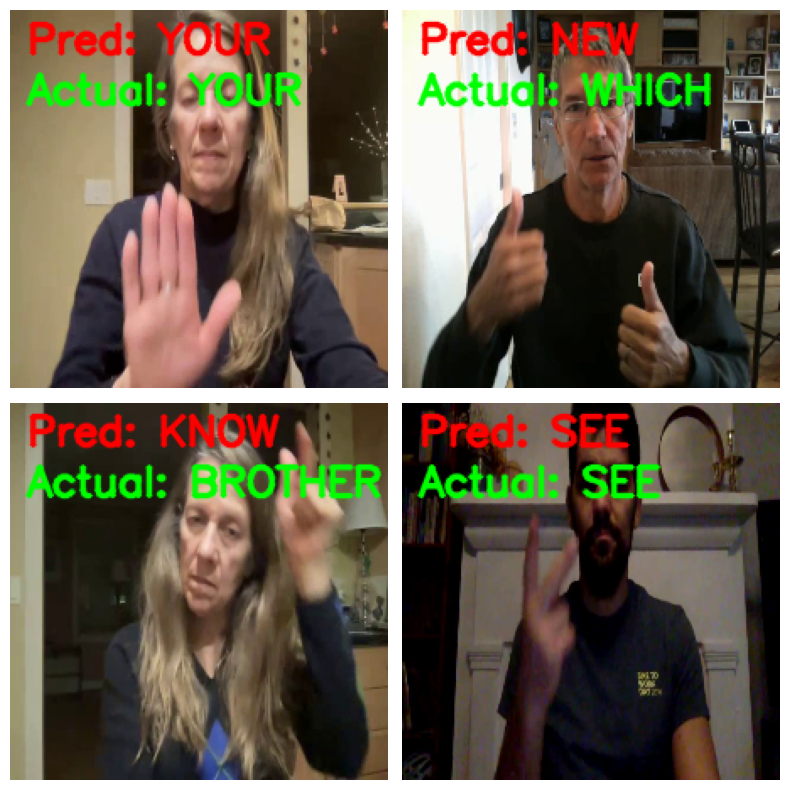

In [ ]:
import os, random, glob, re, cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- CONFIGURE THESE ---
TEST_VIDEO_DIR = '/content/test'
KEYPTS_DIR     = '/content/keypoints_test'
MODEL_PATH     = '/content/model.pth'
CLIP_LEN       = 16
# ------------------------

# 1) Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SwinPF(num_classes=len(train_ds.class_to_idx))
state = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state)
model.to(device).eval()

# 2) Invert mapping
idx_to_class = {v:k for k,v in train_ds.class_to_idx.items()}

# 3) Sample videos
videos  = glob.glob(os.path.join(TEST_VIDEO_DIR, '*.mp4'))
sampled = random.sample(videos, k=min(4, len(videos)))

# 4) Process each and collect images
imgs = []
for vid_path in sampled:
    # a) Read CLIP_LEN frames
    cap, frames = cv2.VideoCapture(vid_path), []
    while len(frames) < CLIP_LEN and cap.isOpened():
        ret, img = cap.read()
        if not ret: break
        frames.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    cap.release()
    if not frames: continue
    if len(frames) < CLIP_LEN:
        frames += [frames[-1]]*(CLIP_LEN - len(frames))
    else:
        frames = frames[:CLIP_LEN]

    # b) Preprocess exactly like your Dataset
    frames_np = np.stack(frames, axis=0)                         # [T,H,W,3]
    f = torch.from_numpy(frames_np).permute(0,3,1,2).float().div(255.0)
    f = F.interpolate(f, size=(224,224), mode='bilinear', align_corners=False)
    mean = torch.tensor([0.485,0.456,0.406])[:,None,None]
    std  = torch.tensor([0.229,0.224,0.225])[:,None,None]
    f = (f - mean) / std                                        # [T,3,224,224]
    vid_tensor = f.permute(1,0,2,3).unsqueeze(0).to(device)      # [1,3,T,224,224]

    # c) Load keypoints
    base      = os.path.basename(vid_path).rsplit('.',1)[0] + '.npy'
    kp        = np.load(os.path.join(KEYPTS_DIR, base))         # [T,33,2]
    kp_tensor = torch.from_numpy(kp).unsqueeze(0).to(device)     # [1,T,33,2]

    # d) Inference
    with torch.no_grad():
        logits   = model(vid_tensor, kp_tensor)
        pred_idx = logits.argmax(1).item()
    pred_label = idx_to_class[pred_idx]

    # e) Get actual label from filename
    name = os.path.splitext(os.path.basename(vid_path))[0]
    parts = name.split('-',1)
    actual = parts[1] if len(parts)==2 else parts[0]
    actual = re.sub(r'(?i)^seed','', actual).strip()
    actual = re.sub(r' \d+$','',    actual).strip()

    # f) Grab & un-normalize middle frame
    mid = CLIP_LEN//2
    frame_t = f[mid] * std + mean       # [3,224,224] un-normalized
    frame   = (frame_t.clamp(0,1).permute(1,2,0).cpu().numpy()*255).astype(np.uint8)

    # g) Overlay text
    cv2.putText(frame, f"Pred: {pred_label}",   (10,25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2, cv2.LINE_AA)
    cv2.putText(frame, f"Actual: {actual}",    (10,55),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2, cv2.LINE_AA)

    imgs.append(frame)

# 5) Plot 2×2 grid
fig, axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.flatten()
for ax, im in zip(axes, imgs):
    ax.imshow(im)
    ax.axis('off')
plt.tight_layout()
plt.show()


<ipython-input-21-10a1837c142e>:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0)


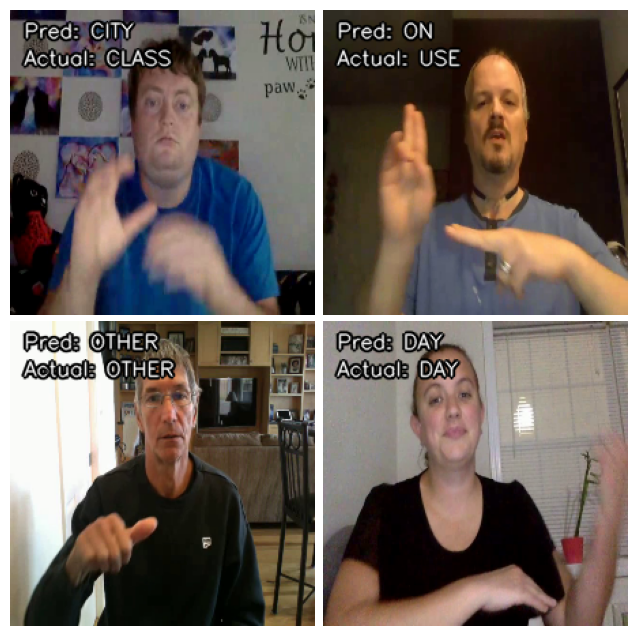

In [ ]:
import os, random, glob, re, cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- CONFIGURE THESE ---
TEST_VIDEO_DIR = '/content/test'
KEYPTS_DIR     = '/content/keypoints_test'
MODEL_PATH     = '/content/model.pth'
CLIP_LEN       = 16
# ------------------------

# 1) Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SwinPF(num_classes=len(train_ds.class_to_idx))
state = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state)
model.to(device).eval()

# 2) Invert mapping
idx_to_class = {v:k for k,v in train_ds.class_to_idx.items()}

# 3) Sample videos
videos  = glob.glob(os.path.join(TEST_VIDEO_DIR, '*.mp4'))
sampled = random.sample(videos, k=min(4, len(videos)))

# 4) Process each and collect images
imgs = []
for vid_path in sampled:
    cap, frames = cv2.VideoCapture(vid_path), []
    while len(frames) < CLIP_LEN and cap.isOpened():
        ret, img = cap.read()
        if not ret: break
        frames.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    cap.release()
    if not frames: continue
    if len(frames) < CLIP_LEN:
        frames += [frames[-1]]*(CLIP_LEN - len(frames))
    else:
        frames = frames[:CLIP_LEN]

    # Preprocess exactly like your Dataset
    frames_np = np.stack(frames, axis=0)                         # [T,H,W,3]
    f = torch.from_numpy(frames_np).permute(0,3,1,2).float().div(255.0)
    f = F.interpolate(f, size=(224,224), mode='bilinear', align_corners=False)
    mean = torch.tensor([0.485,0.456,0.406])[:,None,None]
    std  = torch.tensor([0.229,0.224,0.225])[:,None,None]
    f = (f - mean) / std                                        # [T,3,224,224]
    vid_tensor = f.permute(1,0,2,3).unsqueeze(0).to(device)      # [1,3,T,224,224]

    # Load keypoints
    base      = os.path.basename(vid_path).rsplit('.',1)[0] + '.npy'
    kp        = np.load(os.path.join(KEYPTS_DIR, base))         # [T,33,2]
    kp_tensor = torch.from_numpy(kp).unsqueeze(0).to(device)     # [1,T,33,2]

    # Inference
    with torch.no_grad():
        logits   = model(vid_tensor, kp_tensor)
        pred_idx = logits.argmax(1).item()
    pred_label = idx_to_class[pred_idx]

    # Actual label
    name = os.path.splitext(os.path.basename(vid_path))[0]
    parts = name.split('-',1)
    actual = parts[1] if len(parts)==2 else parts[0]
    actual = re.sub(r'(?i)^seed','', actual).strip()
    actual = re.sub(r' \d+$','',    actual).strip()

    # Grab & un-normalize middle frame
    mid = CLIP_LEN//2
    frame_t = f[mid] * std + mean       # [3,224,224]
    frame   = (frame_t.clamp(0,1).permute(1,2,0).cpu().numpy()*255).astype(np.uint8)

    # Overlay smaller, outlined text
    font       = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness  = 1
    y0 = 20
    for i, text in enumerate([f"Pred: {pred_label}", f"Actual: {actual}"]):
        y = y0 + i*20
        # outline
        cv2.putText(frame, text, (10, y), font, font_scale, (0,0,0), thickness+2, cv2.LINE_AA)
        # foreground
        cv2.putText(frame, text, (10, y), font, font_scale, (255,255,255), thickness, cv2.LINE_AA)

    imgs.append(frame)

# 5) Plot 2×2 grid with minimal margins
fig, axes = plt.subplots(2,2, figsize=(8,8), gridspec_kw={'wspace':0.02,'hspace':0.02})
for ax, im in zip(axes.flatten(), imgs):
    ax.imshow(im)
    ax.axis('off')
plt.tight_layout(pad=0)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# 1) Gather all true & predicted labels
all_trues = []
all_preds = []
model.eval()
with torch.no_grad():
    for vids, kps, labels in test_loader:
        vids, kps = vids.to(device), kps.to(device)
        logits = model(vids, kps)
        all_trues.extend(labels.cpu().numpy())
        all_preds.extend(logits.argmax(1).cpu().numpy())

n_classes = len(train_ds.class_to_idx)
# 2) Compute full confusion matrix
cm = confusion_matrix(all_trues, all_preds,
                      labels=list(range(n_classes)))

# zero out the diagonal so we focus on mistakes
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

# 3) Flatten into (actual, predicted, count) rows
rows = []
for actual_idx in range(n_classes):
    for pred_idx in range(n_classes):
        if actual_idx == pred_idx: continue
        count = cm_no_diag[actual_idx, pred_idx]
        if count>0:
            rows.append((actual_idx, pred_idx, count))

df = pd.DataFrame(rows, columns=['actual_idx','predicted_idx','count'])
df = df.sort_values('count', ascending=False).head(10)

# 4) Map indices back to gloss strings
idx_to_class = {v:k for k,v in train_ds.class_to_idx.items()}
df['actual_gloss']    = df['actual_idx'].map(idx_to_class)
df['predicted_gloss'] = df['predicted_idx'].map(idx_to_class)

# Final table
print(df[['actual_gloss','predicted_gloss','count']])


    actual_gloss predicted_gloss  count
125           MY            LIKE      5
179        THINK             FOR      5
150          OUR             DOG      4
90           FOR           THINK      3
8          AFTER           BRING      3
16           AND            LIKE      3
58         CLASS            CITY      3
54         CARRY            DRAW      3
83         DREAM             FOR      3
39          BIRD             WHO      2


In [ ]:
import os, random, glob, re, cv2, numpy as np, torch, torch.nn.functional as F

# CONFIG
TEST_VIDEO_DIR = '/content/test'
KEYPTS_DIR     = '/content/keypoints_test'
MODEL_PATH     = '/content/model.pth'
CLIP_LEN       = 16
OUTPUT_DIR     = '/content/samples'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1) Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SwinPF(num_classes=len(train_ds.class_to_idx))
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device).eval()

# 2) Invert lookup
idx_to_class = {v:k for k,v in train_ds.class_to_idx.items()}

# 3) Gather all test videos
videos = glob.glob(os.path.join(TEST_VIDEO_DIR, '*.mp4'))
results = []

for vid in videos:
    # infer label
    cap, frames_rgb = cv2.VideoCapture(vid), []
    while len(frames_rgb) < CLIP_LEN and cap.isOpened():
        ret, img = cap.read()
        if not ret: break
        frames_rgb.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    cap.release()
    if not frames_rgb:
        continue
    if len(frames_rgb) < CLIP_LEN:
        frames_rgb += [frames_rgb[-1]] * (CLIP_LEN - len(frames_rgb))
    else:
        frames_rgb = frames_rgb[:CLIP_LEN]

    arr = np.stack(frames_rgb, 0)
    t   = torch.from_numpy(arr).permute(0,3,1,2).float().div(255.0)
    t   = F.interpolate(t, size=(224,224), mode='bilinear', align_corners=False)
    mean = torch.tensor([0.485,0.456,0.406])[:,None,None]
    std  = torch.tensor([0.229,0.224,0.225])[:,None,None]
    t   = (t - mean) / std
    vid_tensor = t.permute(1,0,2,3).unsqueeze(0).to(device)

    # keypoints
    name      = os.path.basename(vid).rsplit('.',1)[0]
    kp        = np.load(os.path.join(KEYPTS_DIR, name+'.npy'))
    kp_tensor = torch.from_numpy(kp).unsqueeze(0).to(device)

    with torch.no_grad():
        pred_idx = model(vid_tensor, kp_tensor).argmax(1).item()
    pred_lbl = idx_to_class[pred_idx]

    # actual
    parts = name.split('-',1)
    actual = (parts[1] if len(parts)==2 else parts[0])
    actual = re.sub(r'(?i)^seed','', actual).strip()
    actual = re.sub(r' \d+$','',    actual).strip()

    results.append({'path': vid, 'actual': actual, 'pred': pred_lbl})

# 4) Split correct vs incorrect
correct   = [r for r in results if r['actual']==r['pred']]
incorrect = [r for r in results if r['actual']!=r['pred']]

# ensure we have at least 2 of each
assert len(correct)>=2 and len(incorrect)>=2, "Need ≥2 correct and ≥2 incorrect examples"

# 5) Sample exactly 2 from each
chosen = random.sample(correct,2) + random.sample(incorrect,2)
random.shuffle(chosen)

# 6) For each chosen video, pick its sharpest frame & save
for i, rec in enumerate(chosen, start=1):
    vid = rec['path']
    # read full clip in BGR
    cap, frames_bgr = cv2.VideoCapture(vid), []
    while len(frames_bgr) < CLIP_LEN and cap.isOpened():
        ret, img_bgr = cap.read()
        if not ret: break
        frames_bgr.append(img_bgr)
    cap.release()
    if len(frames_bgr) < CLIP_LEN:
        frames_bgr += [frames_bgr[-1]] * (CLIP_LEN - len(frames_bgr))
    else:
        frames_bgr = frames_bgr[:CLIP_LEN]

    # pick sharpest
    scores = [cv2.Laplacian(cv2.cvtColor(f, cv2.COLOR_BGR2GRAY), cv2.CV_64F).var()
              for f in frames_bgr]
    best = frames_bgr[int(np.argmax(scores))]

    # save
    out_path = os.path.join(OUTPUT_DIR, f'sample_{i}.png')
    cv2.imwrite(out_path, best)
    print(f"Saved {out_path} — Actual: {rec['actual']} | Predicted: {rec['pred']}")


Saved /content/samples/sample_1.png — Actual: DANCE | Predicted: DANCE
Saved /content/samples/sample_2.png — Actual: BACK | Predicted: MOST
Saved /content/samples/sample_3.png — Actual: ME | Predicted: ME
Saved /content/samples/sample_4.png — Actual: IF | Predicted: BACK


In [ ]:
import os, random, glob, re, cv2, numpy as np, torch, torch.nn.functional as F

# CONFIG
TEST_VIDEO_DIR = '/content/test'
KEYPTS_DIR     = '/content/keypoints_test'
MODEL_PATH     = '/content/model.pth'
CLIP_LEN       = 16
OUTPUT_DIR     = '/content/incorrect_samples'
os.makedirs(OUTPUT_DIR, exist_ok=True)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SwinPF(num_classes=len(train_ds.class_to_idx))
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device).eval()


idx_to_class = {v:k for k,v in train_ds.class_to_idx.items()}


videos = glob.glob(os.path.join(TEST_VIDEO_DIR, '*.mp4'))
results = []
for vid in videos:

    cap, frames_rgb = cv2.VideoCapture(vid), []
    while len(frames_rgb) < CLIP_LEN and cap.isOpened():
        ret, img = cap.read()
        if not ret: break
        frames_rgb.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    cap.release()
    if not frames_rgb:
        continue
    if len(frames_rgb) < CLIP_LEN:
        frames_rgb += [frames_rgb[-1]] * (CLIP_LEN - len(frames_rgb))
    else:
        frames_rgb = frames_rgb[:CLIP_LEN]


    arr = np.stack(frames_rgb, axis=0)
    t   = torch.from_numpy(arr).permute(0,3,1,2).float().div(255.0)
    t   = F.interpolate(t, size=(224,224), mode='bilinear', align_corners=False)
    mean = torch.tensor([0.485,0.456,0.406])[:,None,None]
    std  = torch.tensor([0.229,0.224,0.225])[:,None,None]
    t   = (t - mean) / std
    vid_tensor = t.permute(1,0,2,3).unsqueeze(0).to(device)


    name      = os.path.basename(vid).rsplit('.',1)[0]
    kp        = np.load(os.path.join(KEYPTS_DIR, name + '.npy'))
    kp_tensor = torch.from_numpy(kp).unsqueeze(0).to(device)


    with torch.no_grad():
        pred_idx = model(vid_tensor, kp_tensor).argmax(1).item()
    pred_lbl = idx_to_class[pred_idx]


    parts  = name.split('-', 1)
    actual = (parts[1] if len(parts)==2 else parts[0])
    actual = re.sub(r'(?i)^seed','', actual).strip()
    actual = re.sub(r' \d+$','',    actual).strip()

    results.append({'path': vid, 'actual': actual, 'pred': pred_lbl})


incorrect = [r for r in results if r['actual'] != r['pred']]
assert len(incorrect) >= 10, f"Only found {len(incorrect)} incorrect examples, need at least 10."


chosen = random.sample(incorrect, 10)


for i, rec in enumerate(chosen, start=1):
    vid = rec['path']

    cap, frames_bgr = cv2.VideoCapture(vid), []
    while len(frames_bgr) < CLIP_LEN and cap.isOpened():
        ret, img_bgr = cap.read()
        if not ret: break
        frames_bgr.append(img_bgr)
    cap.release()
    if len(frames_bgr) < CLIP_LEN:
        frames_bgr += [frames_bgr[-1]] * (CLIP_LEN - len(frames_bgr))
    else:
        frames_bgr = frames_bgr[:CLIP_LEN]


    scores = [cv2.Laplacian(cv2.cvtColor(f, cv2.COLOR_BGR2GRAY), cv2.CV_64F).var()
              for f in frames_bgr]
    best_frame = frames_bgr[int(np.argmax(scores))]


    out_path = os.path.join(OUTPUT_DIR, f'incorrect_{i}.png')
    cv2.imwrite(out_path, best_frame)
    print(f"Saved {out_path} — Actual: {rec['actual']}  Predicted: {rec['pred']}")

Saved /content/incorrect_samples/incorrect_1.png — Actual: OTHER  Predicted: THEY
Saved /content/incorrect_samples/incorrect_2.png — Actual: OVER  Predicted: BRING
Saved /content/incorrect_samples/incorrect_3.png — Actual: NOT  Predicted: WHO
Saved /content/incorrect_samples/incorrect_4.png — Actual: DREAM  Predicted: THINK
Saved /content/incorrect_samples/incorrect_5.png — Actual: NOT  Predicted: APPLE
Saved /content/incorrect_samples/incorrect_6.png — Actual: GIVE  Predicted: COME
Saved /content/incorrect_samples/incorrect_7.png — Actual: DREAM  Predicted: FOR
Saved /content/incorrect_samples/incorrect_8.png — Actual: BASEMENT  Predicted: FROM
Saved /content/incorrect_samples/incorrect_9.png — Actual: YOU  Predicted: US
Saved /content/incorrect_samples/incorrect_10.png — Actual: HAVE  Predicted: WELL
